Download the Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thoughtvector/customer-support-on-twitter")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\91776\.cache\kagglehub\datasets\thoughtvector\customer-support-on-twitter\versions\10


Necessary Libraries

In [3]:
import pandas as pd
import numpy as np
import os
import regex as re
import seaborn as sns
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from matplotlib import pyplot as plt
import pickle

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91776\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Checking Dataset Directory

In [4]:
dir_items = os.listdir(path)
print(dir_items)

['sample.csv', 'twcs']


Reading Dataset file

In [5]:
twcs_data = pd.read_csv(path+"\\twcs\\twcs.csv")
twcs_data.sample(10)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
2753530,2928978,810293,True,Wed Nov 29 05:58:37 +0000 2017,@AmazonHelp Thanks for prompt reply. You gave ...,NaN,2928977.0
835078,929992,340652,True,Fri Oct 13 20:15:54 +0000 2017,Hi @115888 for some reason my account wont pla...,929991,NaN
78964,101703,AmazonHelp,False,Thu Nov 30 17:40:33 +0000 2017,"@138280 Leandro do ceú, que emoção! ❤ Quando r...",101704,101705.0
2739578,2914922,AskeBay,False,Tue Nov 28 22:16:57 +0000 2017,"@806872 Thanks for reaching out on this, Jeffr...",2914923,2914924.0
1610314,1764057,530680,True,Thu Nov 09 02:05:04 +0000 2017,@comcastcares Within what two: three weeks of ...,NaN,1764051.0
2580005,2751110,AppleSupport,False,Tue Nov 21 00:56:00 +0000 2017,@770203 We're happy to help. We know how impor...,2751111,2751112.0
2649666,2822338,153412,True,Mon Nov 27 07:47:08 +0000 2017,@AmazonHelp why do I have prime when I order p...,2822337,NaN
747799,835550,SouthwestAir,False,Mon Oct 09 03:18:49 +0000 2017,"@318917 Glad we could help! Hope to see you, a...",NaN,835551.0
117703,145532,148999,True,Fri Nov 24 13:47:15 +0000 2017,@Ask_Spectrum your service is horrible. My int...,145531,NaN
582029,654487,275689,True,Wed Nov 22 22:18:15 +0000 2017,@Uber_Support your driver was sketchy and I ha...,654486,NaN


Data exploration

In [6]:
print(twcs_data.shape)
print(twcs_data.info())
print(twcs_data.isna().sum())

(2811774, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB
None
tweet_id                         0
author_id                        0
inbound                          0
created_at                       0
text                             0
response_tweet_id          1040629
in_response_to_tweet_id     794335
dtype: int64


In [7]:
df = twcs_data.drop(["response_tweet_id","in_response_to_tweet_id"],axis='columns')
df.shape

(2811774, 5)

In [8]:
df = df.sample(10000,random_state=42)
df.shape

(10000, 5)

In [9]:
inbound = df[["inbound"]]
df = df.drop(["tweet_id","author_id","inbound","created_at"],axis='columns')
df.shape

(10000, 1)

Keeping Neccesary data only

In [10]:
df.sample(10)

,text
2011655,@269039 details about all the measures we take...
742861,@AskPlayStation What are the reasons that a di...
695865,@115940 I noticed a spelling error in the menu...
621860,"@286485 Hey, can you please DM your billing ad..."
2772636,"@135766 Hi, yes we can look into that for you...."
273008,@190774 Hello! Can you DM us your gamertag tom...
892897,"🎉When is the party, @delta?🎉 https://t.co/zSOH..."
1774654,@AskLyft What the fuck
1342863,PSA: don't use @116584. My delivery was 2 hour...
1027518,@387936 If there is something specific I can a...


Data Preprocess: Load the spacy to lemmetize the Data

In [11]:
nlp = spacy.load('en_core_web_sm',disable=['tagger','parser', 'ner']) # disabling Named Entity Recognition for speed

In [12]:
#define a function for text cleaning
def text_cleaner(text):

  #remove user mentions
  text = re.sub(r'@[A-Za-z0-9]+','',text)

  #remove hashtags
  #text = re.sub(r'#[A-Za-z0-9]+','',text)

  #remove links
  text = re.sub(r'http\S+', '', text)

  #convering text to lower case
  text = text.lower()

  # fetch only words
  text = re.sub("[^a-z]+", " ", text)

  # removing extra spaces
  text=re.sub("[\s]+"," ",text)

  # creating doc object
  doc=nlp(text)

  # remove stopwords and lemmatize the text
  tokens=[token.lemma_ for token in doc if(token.is_stop==False)]

  #join tokens by space
  return " ".join(tokens)

In [13]:
# perform text cleaning
df['clean_text']= df['text'].apply(text_cleaner)

C:\Users\91776\AppData\Roaming\Python\Python310\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [14]:
df.shape

(10000, 2)

In [15]:
df.sample(10)

,text,clean_text
1403241,"@478458 Hmm, let's take a closer look. Please ...",hmm let s closer look dm account details beg...
1556389,"@517358 That's not good to hear at all, Wesley...",s good hear wesley dm confirmation details hmb
944359,@McDonalds @367612 What? No freebies for Blayr...,freebies blayr c mon step game fans mickey d s
2410403,@731073 Can you please DM us so we can have a ...,dm closer look
307060,@AmazonHelp 2/x Die Gutschrift ist jetzt aber ...,x die gutschrift ist jetzt aber da passiert ...
1304629,@453766 There are some services that are opera...,services operating delayed situation
614232,@AmericanAir They better had made it after all...,better lol
290054,@195011 I'm here to save the day! Send me a DM...,m save day send dm help nataliekelm
1537445,@512396 Oh no! Now that *is* a baking horror s...,oh baking horror story pam
1685219,"@195948 Great question, I'll make sure you get...",great question ll sure best deal dm ll work ...


Generating the Labeled data to Train the model using SentimentIntensityAnalyzer

In [16]:
def sentiment_analyzer_scores(df,label):
    sid = SentimentIntensityAnalyzer()
    df['negative'] = df[label].apply(lambda x: sid.polarity_scores(x)['neg'])
    df['positive'] = df[label].apply(lambda x: sid.polarity_scores(x)['pos'])
    df['neutral'] = df[label].apply(lambda x: sid.polarity_scores(x)['neu'])
    df['compound'] = df[label].apply(lambda x: sid.polarity_scores(x)['compound'])
    return df

In [17]:
df2 = sentiment_analyzer_scores(df,'clean_text')
df2.sample(10)

,text,clean_text,negative,positive,neutral,compound
1941771,@619418 We want to know what occurred to make ...,want know occurred feel way dm zip code deta...,0.0,0.126,0.874,0.0772
1994113,@632214 Here’s what you can do to work around ...,s work issue s fixed future software update,0.0,0.000,1.000,0.0000
2472920,"@585969 Please can you DM the full name, addre...",dm address email address registered grocery ...,0.0,0.274,0.726,0.5267
1976939,@544202 Send us a DM. We'll be happy to help o...,send dm ll happy help,0.0,0.681,0.319,0.7506
2698529,@281356 @115913 We would love to look into thi...,love look let s chat dm stephaniegarza,0.0,0.457,0.543,0.6369
717683,@115777 @115858 please work! I need to work on...,work need work projects hs os update t work,0.0,0.000,1.000,0.0000
367827,@215238 I understand the urgency. Please share...,understand urgency share details ll look rig...,0.0,0.216,0.784,0.2960
562369,@270205 On a real note: Who's going to step up...,real note s going step help friend swing,0.0,0.541,0.459,0.7096
2228353,@688907 😂 We can be best friends then 😂,best friends,0.0,1.000,0.000,0.8074
2435419,"@KFC_UKI_Help turned up at my local KFC, waite...",uki help turned local kfc waited mins served...,0.0,0.213,0.787,0.4019


In [18]:
# Classify sentiment based on scores
def classify_sentiment(row):
    if row['compound'] >= 0.05:
        return 'positive'
    elif row['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [19]:
df2['sentiment'] = df2.apply(classify_sentiment, axis=1)

In [20]:
df2.sample(10)

,text,clean_text,negative,positive,neutral,compound,sentiment
1666157,"@546121 Hi Jordna, I'm glad you enjoyed your v...",hi jordna m glad enjoyed visit confirm store...,0.000,0.441,0.559,0.7430,positive
2381907,@AmazonHelp If you are not having any solution...,having solution customer problems shut twitt...,0.270,0.230,0.500,-0.1027,negative
2593098,"Not what I expected my sandwich to look like, ...",expected sandwich look like taste good didn t ...,0.000,0.329,0.671,0.6597,positive
489590,Hey @115858 how do I explain this to my kid? T...,hey explain kid arbitrary translate daddy don ...,0.000,0.000,1.000,0.0000,neutral
784319,@AppleSupport why does my WiFi not want to sta...,wifi want stay connected,0.000,0.302,0.698,0.0772,positive
1255956,Nothing beats pre-booking seats on @VirginTrai...,beats pre booking seats train randomly cancell...,0.133,0.200,0.667,0.2500,positive
1008687,"@AmericanAir, what can you tell me about getti...",tell getting media credentials gear cases ba...,0.000,0.000,1.000,0.0000,neutral
1927562,"@185406 Thanks for reaching out, Satej. If you...",thanks reaching satej cancellation fee belie...,0.000,0.370,0.630,0.5719,positive
248965,@AskPlayStation Thank you :),thank,0.000,1.000,0.000,0.3612,positive
2602189,@AmericanAir - I am booked to fly #FirstClass ...,booked fly firstclass caymanislands london m...,0.000,0.091,0.909,0.0772,positive


In [21]:
df2['sentiment'].value_counts()

positive    5189
neutral     2808
negative    2003
Name: sentiment, dtype: int64

<Axes: >

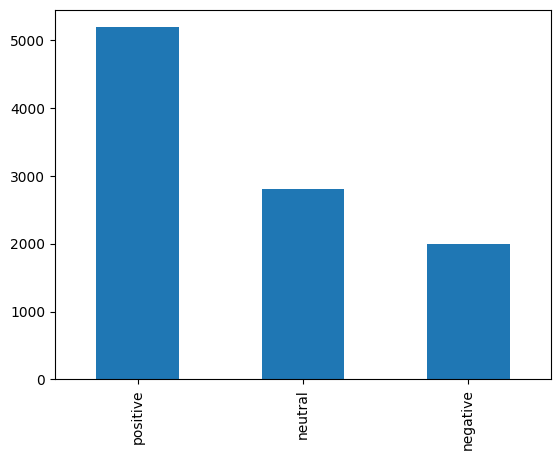

In [22]:
df2['sentiment'].value_counts().plot(kind='bar')

Lebel Encoding the negative neutral and positive

In [23]:
le = LabelEncoder()
df2['sentiment'] = le.fit_transform(df2['sentiment'])
df2.sample(10)

,text,clean_text,negative,positive,neutral,compound,sentiment
2407296,@AmericanAir Done.,,0.000,0.000,0.000,0.0000,1
1698906,@Ask_WellsFargo No thanks. Lets just say my c...,wellsfargo thanks lets children want thier m...,0.000,0.457,0.543,0.4939,2
1947838,@British_Airways REFUND THE MONEY YOU BLOODY I...,airways refund money bloody idiots,0.420,0.000,0.580,-0.4404,0
888378,@353902 Avez-vous contacté notre SAV par rappo...,avez vous contact notre sav par rapport cet ...,0.000,0.000,1.000,0.0000,1
1675051,@Uber_Support You've paid now finally (after r...,support ve paid finally refusing phone night...,0.304,0.161,0.536,-0.3400,0
2153360,@115765 @ATVIAssist Will Headquarters be back ...,headquarters online week,0.000,0.000,1.000,0.0000,1
1005491,Wtf is going on @115911?? This has been doing ...,wtf going day service data service message pops,0.352,0.000,0.648,-0.5859,0
595907,@171800 Thank you! ^NV,thank nv,0.000,0.714,0.286,0.3612,2
134865,@ATVIAssist @153945 The cod points I can’t red...,cod points t redeem,0.000,0.000,1.000,0.0000,1
1808483,@513072 Hey there! This concerns us and we'd l...,hey concerns d love review send dm follow pr...,0.000,0.318,0.682,0.6369,2


In [24]:
le.inverse_transform([0,1,2])

array(['negative', 'neutral', 'positive'], dtype=object)

Splitting the Dataset into Train & Test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df2['clean_text'], df2['sentiment'], test_size=0.2, random_state=42)

In [26]:
print('Shape of X train:',X_train.shape,'Shape of y Train:',y_train.shape)
print('Shape of X Test:',X_test.shape,'Shape of y Test:',y_test.shape)

Shape of X train: (8000,) Shape of y Train: (8000,)
Shape of X Test: (2000,) Shape of y Test: (2000,)


Using Term Frequency and Inverse Term Frequency Vetorizer to convert texts into matrix

In [27]:
word_vectorizer = TfidfVectorizer(max_features=1000)

In [28]:
word_vectorizer.fit(X_train)

TfidfVectorizer(max_features=1000)

In [29]:
train_word_features = word_vectorizer.transform(X_train)
test_word_features = word_vectorizer.transform(X_test)

# Logistic Regression

In [30]:
lr_model = LogisticRegression()
lr_model.fit(train_word_features, y_train) 

LogisticRegression()

In [31]:
train_preds_lr = lr_model.predict(train_word_features)
train_preds_lr

array([1, 2, 2, ..., 2, 1, 1])

In [32]:
print('Train Accuracy:',accuracy_score(y_train,train_preds_lr))

Train Accuracy: 0.876625


In [33]:
lr_model.score(train_word_features, y_train)

0.876625

In [34]:
# Evaluating on Training Set
print("F1-score on Train Set:",f1_score(y_train,train_preds_lr,average="weighted"))

F1-score on Train Set: 0.8755602524474579


In [35]:
print("Confusion Matrix on Train Set:\n",confusion_matrix(y_train,train_preds_lr))

Confusion Matrix on Train Set:
 [[1180  267  196]
 [  68 2041  119]
 [  86  251 3792]]


In [36]:
cm = confusion_matrix(y_train,train_preds_lr)

In [37]:
print("Classification Report on Train Set:\n",classification_report(y_train,train_preds_lr))

Classification Report on Train Set:
               precision    recall  f1-score   support

           0       0.88      0.72      0.79      1643
           1       0.80      0.92      0.85      2228
           2       0.92      0.92      0.92      4129

    accuracy                           0.88      8000
   macro avg       0.87      0.85      0.86      8000
weighted avg       0.88      0.88      0.88      8000



Text(70.72222222222221, 0.5, 'Predicted label')

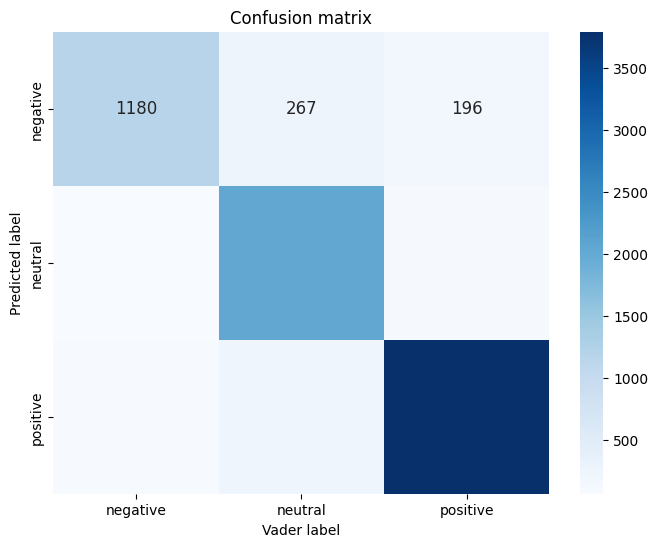

In [38]:
 # plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            annot_kws={'size':12}, 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion matrix')
plt.xlabel('Vader label')
plt.ylabel('Predicted label')

# Random Forest Classifier

In [39]:
RFC_model = RandomForestClassifier()
RFC_model.fit(train_word_features, y_train)

RandomForestClassifier()

In [40]:
train_preds_RFC = RFC_model.predict(train_word_features)
train_preds_RFC

array([1, 2, 2, ..., 2, 1, 1])

In [41]:
print('Train Accuracy:',accuracy_score(y_train,train_preds_RFC))

Train Accuracy: 0.99175


In [42]:
# Evaluating on Training Set
print("F1-score on Train Set:",f1_score(y_train,train_preds_RFC,average="weighted"))

F1-score on Train Set: 0.9917715814717754


In [43]:
print("Confusion Matrix on Train Set:\n",confusion_matrix(y_train,train_preds_RFC))

Confusion Matrix on Train Set:
 [[1614   27    2]
 [   1 2222    5]
 [   1   30 4098]]


In [44]:
cm_RFC = confusion_matrix(y_train,train_preds_lr)

Text(70.72222222222221, 0.5, 'Predicted label')

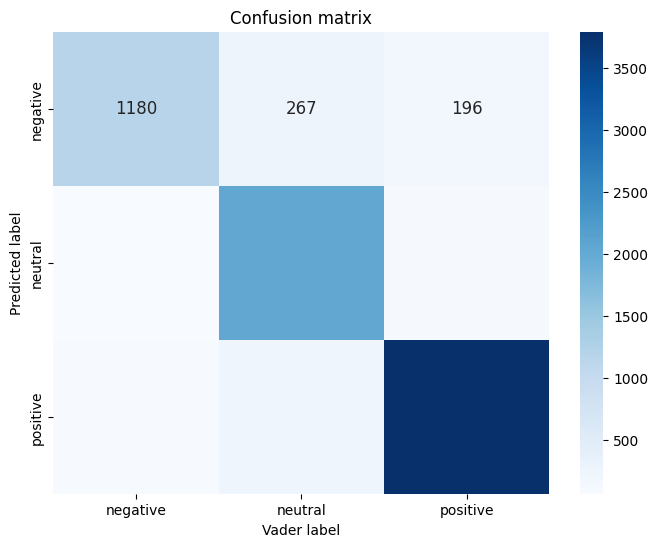

In [45]:
 # plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_RFC, cmap=plt.cm.Blues, annot=True, fmt='d', 
            annot_kws={'size':12}, 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion matrix')
plt.xlabel('Vader label')
plt.ylabel('Predicted label')

In [46]:
print("Classification Report on Train Set:\n",classification_report(y_train,train_preds_RFC))

Classification Report on Train Set:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1643
           1       0.97      1.00      0.99      2228
           2       1.00      0.99      1.00      4129

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



Dumping the trained model

In [48]:
with open('Sentiment_analyse_RFC_model.pkl','wb') as file:
    pickle.dump(RFC_model,file)
# pickle.dump(RFC_model, 'Sentiment_analyse_RFC_model.pkl')

In [51]:
# test = pickle.load('Sentiment_analyse_RFC_model.pkl','rb')
with open ("Sentiment_analyse_RFC_model.pkl",'rb') as file:
    test = pickle.load(file)

In [52]:
input_text = "I’m really unhappy with this service!"
cleaned_input_text = text_cleaner(input_text)
vector_input_text = word_vectorizer.transform([cleaned_input_text])
prediction = test.predict(vector_input_text)
print(prediction)

[1]


C:\Users\91776\AppData\Roaming\Python\Python310\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
